In [1]:
# Tutorial of CADGMs on a non-additive noisy regression:

# y = log(10(|x − 0.03| + 0.03)) (sin(\pi(|x − 0.03| + 0.03) + 2\delta(x)) + \delta(x))
# where \delta = \frac{\epsilon}{exp(2(| x - 0.03| + 0.03))}, and \epsilon \sim N(0, 0.5^2)

# More examples can be found in paper:  
#Yibo, Yang and Paris Perdikaris. "Conditional deep surrogate models for stochastic, high-dimensional, and multi-fidelity systems."  on Computational Mechanics

In [2]:
import tensorflow as tf
import numpy as np
import timeit

class Regression:
    # Initialize the class
    def __init__(self, X, Y, layers_P, layers_Q, layers_T, lam = 1.0):
                
        # Normalize data
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        self.Ymean, self.Ystd = Y.mean(0), Y.std(0)
        X = (X - self.Xmean) / self.Xstd
        Y = (Y - self.Ymean) / self.Ystd
     
        self.X = X
        self.Y = Y
        
        self.layers_P = layers_P
        self.layers_Q = layers_Q
        self.layers_T = layers_T
        
        self.X_dim = X.shape[1]
        self.Y_dim = Y.shape[1]
        self.Z_dim = layers_Q[-1]
        self.lam = lam
        self.k1 = 2
        self.k2 = 1    

        # Initialize network weights and biases        
        self.weights_P, self.biases_P = self.initialize_NN(layers_P)
        self.weights_Q, self.biases_Q = self.initialize_NN(layers_Q)
        self.weights_T, self.biases_T = self.initialize_NN(layers_T)
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        
        # Define placeholders and computational graph
        self.X_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.Y_tf = tf.placeholder(tf.float32, shape=(None, self.Y_dim))
        self.Z_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))
        
        # Symmetric VAE loss (to be minimized)
        self.G_loss, self.KL_loss, self.recon_loss  = self.compute_KL_loss(self.X_tf, self.Y_tf, self.Z_tf)
        
        # Discriminator loss
        self.T_loss  = self.compute_T_loss(self.X_tf, self.Y_tf, self.Z_tf)
        
        self.sample = self.sample_generator(self.X_tf, self.Z_tf)

        # Define optimizer        
        self.optimizer_KL = tf.train.AdamOptimizer(1e-4)
        self.optimizer_T = tf.train.AdamOptimizer(1e-4)
        
        # Define train Ops
        self.train_op_KL = self.optimizer_KL.minimize(self.G_loss, 
                                                      var_list = [self.weights_P, self.biases_P,
                                                                  self.weights_Q, self.biases_Q])
                                                                    
        self.train_op_T = self.optimizer_T.minimize(self.T_loss,
                                                    var_list = [self.weights_T, self.biases_T])

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
           
           
    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    
    # Decoder: p(y|x,z)
    def net_P(self, X, Z):
        Y = self.forward_pass(tf.concat([X, Z], 1),
                              self.layers_P,
                              self.weights_P,
                              self.biases_P)
        return Y
    
    # Encoder: q(z|x,y)
    def net_Q(self, X, Y):
        Z = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_Q,
                              self.weights_Q,
                              self.biases_Q)
        return Z
    
    # Discriminator
    def net_T(self, X, Y):
        T = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_T,
                              self.weights_T,
                              self.biases_T)        
        return T
    
    
    def compute_KL_loss(self, X, Y, Z):  
        # Prior: p(z)
        z_prior = Z
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)        
        # Encoder: q(z|x,y)
        z_encoder = self.net_Q(X, Y_pred)
        # Discriminator loss
        T_pred = self.net_T(X, Y_pred)
        
        KL = tf.reduce_mean(T_pred)
        log_q = -tf.reduce_mean(tf.square(z_prior-z_encoder))
        loss = KL + (1.0-self.lam)*log_q
        
        return loss, KL, log_q
    
    
    def compute_T_loss(self, X, Y, Z): 
        # Prior: p(z)
        z_prior = Z
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)                
        
        # Discriminator loss
        T_real = self.net_T(X, Y)
        T_fake = self.net_T(X, Y_pred)
        
        T_real = tf.sigmoid(T_real)
        T_fake = tf.sigmoid(T_fake)
        
        T_loss = -tf.reduce_mean(tf.log(1.0 - T_real + 1e-8) + \
                                 tf.log(T_fake + 1e-8)) 
        
        return T_loss
           
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, Y, N_batch):
        N = X.shape[0]
        idx = np.random.choice(N, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
    
    
    # Trains the model
    def train(self, nIter = 10000, batch_size = 100): 

        start_time = timeit.default_timer()
        for it in range(nIter):     
            # Fetch a mini-batch of data
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)
            Z = np.random.randn(X_batch.shape[0], 1)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.X_tf: X_batch, self.Y_tf: Y_batch, self.Z_tf: Z}  
            
            # Run the Tensorflow session to minimize the loss
            for i in range(self.k1):
                self.sess.run(self.train_op_T, tf_dict)
            for j in range(self.k2):
                self.sess.run(self.train_op_KL, tf_dict)   
            
            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_KL_value, reconv = self.sess.run([self.KL_loss, self.recon_loss], tf_dict)
                loss_T_value = self.sess.run(self.T_loss, tf_dict)
                print('It: %d, KL_loss: %.2e, Recon_loss: %.2e, T_loss: %.2e, Time: %.2f' % 
                      (it, loss_KL_value, reconv, loss_T_value, elapsed))
                start_time = timeit.default_timer()
                
                
    def sample_generator(self, X, Z):        
        # Prior: p(z)
        z_prior = Z       
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)      
        return Y_pred
    
    def generate_sample(self, X_star):
        X_star = (X_star - self.Xmean) / self.Xstd
        Z = np.random.randn(X_star.shape[0], 1)
        tf_dict = {self.X_tf: X_star, self.Z_tf: Z}       
        Y_star = self.sess.run(self.sample, tf_dict) 
        # De-normalize outputs
        Y_star = Y_star * self.Ystd + self.Ymean
        return Y_star

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata

np.random.seed(1234)
    
N = 200
X_dim = 1
Y_dim = 1
Z_dim = 1
err_var = 0.5

# Generate training data
X = np.linspace(-2., 2.,N)[:,None]
error = 1.0/np.exp(2.0*(abs(X-0.03)+0.03))*np.random.normal(0,err_var,X.size)[:,None]
def ff(X, error):
    return np.log(10.0*(abs(X-0.03)+0.03))*(np.sin(np.pi*(abs(X-0.03)+0.03)+2*error)+error)

Y = ff(X,error)

# Noise free exact relation between y and x
def f(X):
    return np.log(10.0*(abs(X-0.03)+0.03))*np.sin(np.pi*(abs(X-0.03)+0.03))

# Generate test data
N_star = 2000
X_star = np.linspace(-2.,2.,N_star)[:,None]
Y_star = f(X_star)  

In [4]:
# Model creation
layers_P = np.array([X_dim+Z_dim,100,100,100,Y_dim])
layers_Q = np.array([X_dim+Y_dim,100,100,100,Z_dim])  
layers_T = np.array([X_dim+Y_dim,100,100,1])       
model = Regression(X, Y, layers_P, layers_Q, layers_T, lam = 1.5)

# Train model
model.train(nIter = 20000, batch_size = N)

Instructions for updating:
Colocations handled automatically by placer.
It: 0, KL_loss: -4.96e-04, Recon_loss: -8.38e-01, T_loss: 1.41e+00, Time: 1.00
It: 100, KL_loss: 4.04e-03, Recon_loss: -1.91e-02, T_loss: 1.38e+00, Time: 3.68
It: 200, KL_loss: 4.81e-02, Recon_loss: -1.57e-02, T_loss: 1.34e+00, Time: 3.56
It: 300, KL_loss: 8.83e-02, Recon_loss: -2.80e-02, T_loss: 1.30e+00, Time: 3.56
It: 400, KL_loss: 3.04e-01, Recon_loss: -1.89e-02, T_loss: 1.19e+00, Time: 3.37
It: 500, KL_loss: 2.85e-01, Recon_loss: -1.31e-02, T_loss: 1.21e+00, Time: 3.56
It: 600, KL_loss: 3.01e-01, Recon_loss: -1.09e-01, T_loss: 1.25e+00, Time: 3.55
It: 700, KL_loss: 2.29e-01, Recon_loss: -2.17e-01, T_loss: 1.31e+00, Time: 3.37
It: 800, KL_loss: 2.32e-01, Recon_loss: -4.14e-01, T_loss: 1.33e+00, Time: 3.56
It: 900, KL_loss: 6.20e-02, Recon_loss: -3.79e-01, T_loss: 1.37e+00, Time: 3.56
It: 1000, KL_loss: 7.74e-02, Recon_loss: -2.88e-01, T_loss: 1.36e+00, Time: 3.37
It: 1100, KL_loss: 3.04e-02, Recon_loss: -1.36e-

It: 9800, KL_loss: 1.16e-01, Recon_loss: -2.09e-01, T_loss: 1.31e+00, Time: 3.55
It: 9900, KL_loss: 8.61e-02, Recon_loss: -2.38e-01, T_loss: 1.33e+00, Time: 3.56
It: 10000, KL_loss: 8.95e-02, Recon_loss: -2.31e-01, T_loss: 1.33e+00, Time: 3.40
It: 10100, KL_loss: 6.88e-02, Recon_loss: -2.13e-01, T_loss: 1.34e+00, Time: 3.60
It: 10200, KL_loss: 9.08e-02, Recon_loss: -2.24e-01, T_loss: 1.33e+00, Time: 3.58
It: 10300, KL_loss: 1.13e-01, Recon_loss: -2.35e-01, T_loss: 1.33e+00, Time: 3.56
It: 10400, KL_loss: 1.10e-01, Recon_loss: -1.97e-01, T_loss: 1.32e+00, Time: 3.38
It: 10500, KL_loss: 9.38e-02, Recon_loss: -1.83e-01, T_loss: 1.32e+00, Time: 3.59
It: 10600, KL_loss: 9.17e-02, Recon_loss: -2.27e-01, T_loss: 1.33e+00, Time: 3.56
It: 10700, KL_loss: 8.92e-02, Recon_loss: -2.49e-01, T_loss: 1.32e+00, Time: 3.38
It: 10800, KL_loss: 1.09e-01, Recon_loss: -2.16e-01, T_loss: 1.32e+00, Time: 3.56
It: 10900, KL_loss: 1.06e-01, Recon_loss: -2.40e-01, T_loss: 1.32e+00, Time: 3.55
It: 11000, KL_loss

It: 19800, KL_loss: 6.05e-02, Recon_loss: -1.05e-01, T_loss: 1.34e+00, Time: 3.56
It: 19900, KL_loss: 8.05e-02, Recon_loss: -1.10e-01, T_loss: 1.34e+00, Time: 3.38


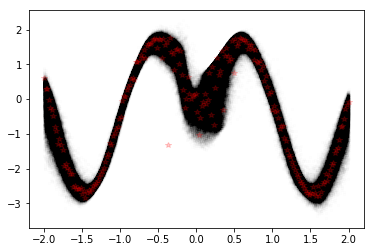

In [5]:
# Prediction
plt.figure(1)
N_samples = 500
samples_mean = np.zeros((X_star.shape[0], N_samples))
for i in range(0, N_samples):
    samples_mean[:,i:i+1] = model.generate_sample(X_star)
    plt.plot(X_star, samples_mean[:,i:i+1],'k.', alpha = 0.005)
plt.plot(X, Y, 'r*',alpha = 0.2, label = '%d training data' % N)

# Compute mean and variance
mu_pred = np.mean(samples_mean, axis = 1)    
Sigma_pred = np.var(samples_mean, axis = 1)  

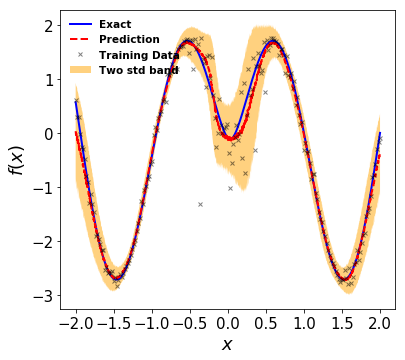

In [6]:
# Plotting the results
plt.figure(2, figsize=(6, 5.5), facecolor='w', edgecolor='k')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(X_star, Y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(X_star, mu_pred, 'r--', label = "Prediction", linewidth=2)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X, Y, 'kx', alpha = 0.5, label = 'Training Data', markersize = 4)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$f(x)$',fontsize=18)
plt.legend(loc='upper left', frameon=False, prop={'size': 10.5, 'weight': 'extra bold'})
plt.show()